# DECam image querying

This is currently just a test to see if image querying + fits file displaying works

Primarily from the [NOIRLab API examples](https://github.com/NOAO/nat-nb/blob/master/sia.ipynb)

In [21]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## Downloading images from the Legacy Survey

Files are accessed through the DR10 Web Access directories mentioned on the [Legacy Survey Website](https://www.legacysurvey.org/dr10/files/).


TO DO:
- error checking if the image at the given section and brick don't exist
- figure out a method to find out which brick corresponds to a given RA/DEC

In [2]:
def obtain_image(brick, filter, reset_cache=True):
    """Returns the header and data for a coadded FITS file queried from the Legacy Survey DR10 portal
    
    Files are accessed with a url pattern of `<section>/<brick>/legacysurvey-<brick>-image-<filter>.fits.fz`
    as documented on the [Legacy Survey website](https://www.legacysurvey.org/dr10/files/#image-stacks-south-coadd).
    Images can be deleted from cache after the header and data are extracted.
    
    Parameters
    ----------
    brick:  `str`
        Brick name of image: RRRr(p/m)DDd
    filter: `str`
        Photographic filter of image to request (g, r, i, z)
    reset_cache: `bool`, default `True`
        Clears the downloaded image from the cache
        
    Returns
    -------
    header: `CompImageHeader`
        Astropy object of the FITS header data
    data: `ndarray`
        Numpy NDarray of FITS image data
    """
    
    url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
    image_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-image-{filter}.fits.fz"
    
    print(f"Downloading {image_string}....")

    # assumes only one image, in the first non-primary header file
    with fits.open(image_string) as hdu:
        header = hdu[1].header
        data = hdu[1].data
    
    if reset_cache:
        print("Clearing download cache...")
        data_utils.clear_download_cache(image_string)
    
    return header, data

header, data = obtain_image("0001m002", "g", reset_cache=False)

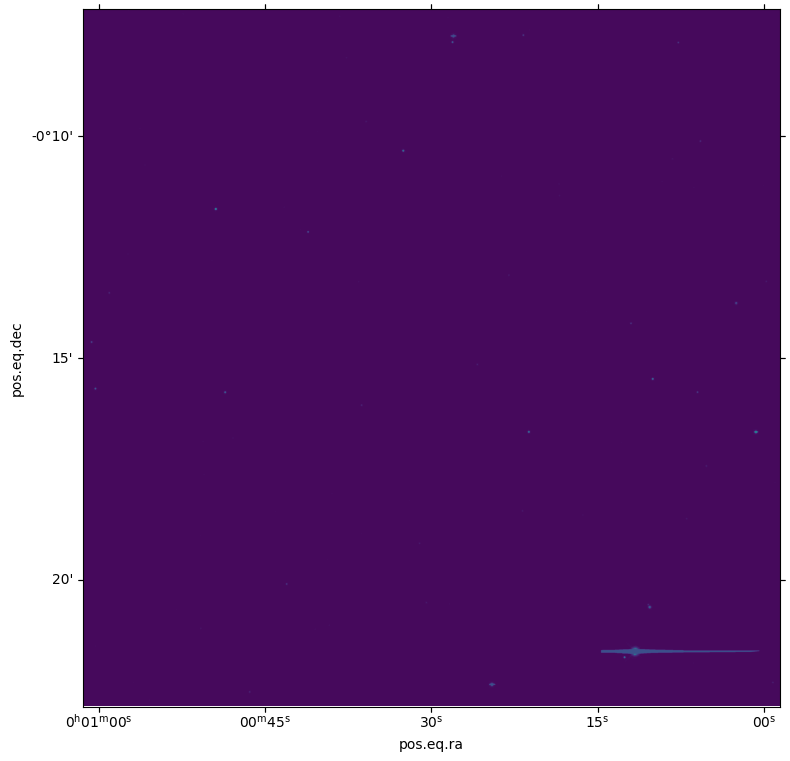

In [3]:
def plot_image(header, data):
    """Plots the image based on header and image data"""
    
    wcs = WCS(header)

    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection=wcs)
    lon = ax.coords['ra']
    lat = ax.coords['dec']
    ax.imshow(data, norm='linear')

    plt.tight_layout()
    
plot_image(header, data)

## Querying the NOIRLab Astro Data Lab

to get the images we need:
- query the data lab for brick names in some RA/DEC region (ls_dr10.bricks)
- iterate through the list of brick names
- for each brick name:
  - download the image associated with it
  - extract header and image data
  - send to source extraction etc...

In [4]:
# this function isn't actually necessary...
def brick_identifier(ra, dec):
    """Creates a string corresponding to the brick name of the image at a given RA/DEC
    in the format `RRRr(p/m)DDd`
    
    Example: (0.125, -0.25) -> 0001m002
    
    Parameters
    ----------
    ra: `float`
        Right ascension (degrees)
    dec: `float`
        Declination (degrees)
        
    Returns
    -------
    brickname: `str`
        Name of "brick" image
    """
    # ra RRR.rrr -> RRRr
    # dec (+/-)DD.ddd -> (p/m)DDd
    
    # whether declination is positive or negative
    sign = "p"
    if dec < 0:
        sign = "m"
    
    # remove decimal and sign
    mod_ra = round(ra*10)
    mod_dec = abs(round(dec*10))
    
    brickname = f"{mod_ra:04}{sign}{mod_dec:03}"
    print(f"Brick name for RA={ra} and DEC={dec}: {brickname}")
    
    return brickname
    
brickname = brick_identifier(0.125, -0.25)

Brick name for RA=0.125 and DEC=-0.25: 0001m002


In [16]:
print(qc.schema("ls_dr10.bricks"))


Schema: ls_dr10
 Table: bricks

     Column Name   Description
     -----------   -----------
       brickname   Name of the brick
         brickid   A unique integer with 1-to-1 mapping to brickname
          brickq   A "priority" factor used for processing
        brickrow   Dec row number
        brickcol   Number of the brick within a Dec row
              ra   RA of the center of the brick
             dec   Dec of the center of the brick
             ra1   Lower RA boundary
             ra2   Upper RA boundary
            dec1   Lower Dec boundary
            dec2   Upper Dec boundary



In [ ]:
def query_bricks(ra, dec, dist):
    """Queries the Astro Data Lab for brick names and associated RA/DEC based on the given RA/DEC
    
    dist is in degrees
    """
    
    # one RA/DEC pair, then some set range around that?
    ra_max = ra + dist
    ra_min = ra - dist
    dec_max = dec + dist
    dec_min = dec - dist
    
    # bounded RA/DEC region?
    
    # centers or corners of bricks?

    query = f"""
    SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
    FROM ls_dr10.bricks
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    LIMIT 10
    """
    
    print(query)
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    
    return brick_info

brick_df = query_bricks(100, 15, 0.5)


    SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
    FROM ls_dr10.bricks
    WHERE ra > (99.5) AND ra < (100.5)
    AND dec > (14.5) AND dec < (15.5)
    LIMIT 10
    
Querying the Astro Data Lab...


In [30]:
brick_df

,brickname,ra,ra1,ra2,dec,dec1,dec2
0,0996p150,99.698276,99.568966,99.827586,15.00,14.875,15.125
1,0999p150,99.956897,99.827586,100.086207,15.00,14.875,15.125
2,1002p150,100.215517,100.086207,100.344828,15.00,14.875,15.125
3,1004p150,100.474138,100.344828,100.603448,15.00,14.875,15.125
4,0996p152,99.698276,99.568966,99.827586,15.25,15.125,15.375
5,0999p152,99.956897,99.827586,100.086207,15.25,15.125,15.375
6,1002p152,100.215517,100.086207,100.344828,15.25,15.125,15.375
7,1004p152,100.474138,100.344828,100.603448,15.25,15.125,15.375
8,0995p147,99.555237,99.426112,99.684362,14.75,14.625,14.875
9,0998p147,99.813486,99.684362,99.942611,14.75,14.625,14.875


In [34]:
def iterate_bricks(brick_df):
    """Iterate through a dataframe of brick names and generate the images from them
    """
    
    # image_array = []
    
    for brick in brick_df['brickname']:
        print(brick)
        
iterate_bricks(brick_df)

0996p150
0999p150
1002p150
1004p150
0996p152
0999p152
1002p152
1004p152
0995p147
0998p147
